In [1]:
from jadeR import jadeR
import pandas as pd
from wfield import *


In [2]:
# %% set path and parameter
path_wfield = r'/home/lzx/data/WF_VC_liuzhaoxi/P73/20240718/natural-movie/process/20240718-170059-wfield'
experiment = os.path.basename(path_wfield)[:15]
path_out = pjoin(path_wfield, '..', experiment + '-natural-movie', 'ICA')
os.makedirs(path_out, exist_ok=True)
rawPath = pjoin(path_wfield, '../../raw')
movie_folder = pjoin(rawPath, 'natural_movies')
movie_list = pd.read_csv(pjoin(movie_folder, 'movie_list.txt'), header=None).values
n_movie = movie_list.size
movie_name_list = []
for imovie in range(n_movie):
    movie_name_list.append(str(movie_list[imovie])[2:-6])

n_frame = 150  # 帧


In [3]:
# load wfield data
U = np.load(pjoin(path_wfield, 'U.npy')).astype('float32')
SVTcorr = np.load(pjoin(path_wfield, 'SVTcorr.npy')).astype('float32')
tif_corr = reconstruct(U, SVTcorr)


In [ ]:
n_IC = 50
X = tif_corr.reshape(SVTcorr.shape[-1], -1)
print('ICA dim:', X.shape)

demix_matrix = jadeR(X, m=n_IC, verbose=True)
IC = demix_matrix * X
IC_array = np.asarray(IC).reshape(n_IC, *U.shape[:-1])
mix_matrix = np.linalg.pinv(demix_matrix)

np.save(pjoin(path_out, 'spatial_IC.npy'), IC_array)
np.save(pjoin(path_out, 'IC_timecourse(mix_matrix).npy'), mix_matrix)
print('save ICA matrix')

In [5]:
from wfield import *

lmarks = load_allen_landmarks(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'))
ccf_regions_reference, proj, brain_outline = allen_load_reference('dorsal_cortex')
# this loads the untransformed atlas
atlas_im, areanames, brain_mask = atlas_from_landmarks_file(pjoin(path_wfield, 'dorsal_cortex_landmarks.json'),
                                                            do_transform=True)
# this converts the reference to image space (unwarped)
ccf_regions_im = allen_transform_regions(lmarks['transform'], ccf_regions_reference,
                                         resolution=lmarks['resolution'],
                                         bregma_offset=lmarks['bregma_offset'])


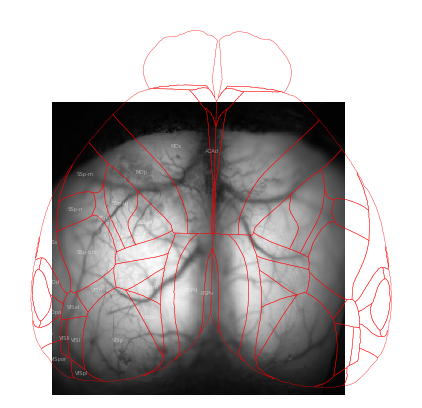

In [6]:
frames_ave = np.load(pjoin(path_wfield, 'frames_average.npy'))[0]
merge_frame_size = (512, 512)  # (width, height)
fig = plt.figure(figsize=(merge_frame_size[0] / 128, merge_frame_size[1] / 128), dpi=128)
plt.imshow(frames_ave, cmap='gray')
for i, r in ccf_regions_im.iterrows():
    plt.plot(r['left_x'], r['left_y'], 'r', lw=0.2)
    plt.plot(r['right_x'], r['right_y'], 'r', lw=0.2)
    plt.text(r.left_center[0], r.left_center[1], r.acronym, color='w', va='center', fontsize=3, alpha=0.5, ha='center')

plt.axis('off')
fig.set_facecolor('white')
# plt.savefig(pjoin(path_out, 'ccf.png'), bbox_inches='tight', pad_inches=0)
plt.show()


In [15]:
def zscore(matrix, axis=0):
    mean = np.mean(matrix, axis=axis)
    std = np.std(matrix, axis=axis)
    zscore_matrix = (matrix - mean) / std
    return zscore_matrix


IC_z = zscore(IC, axis=0)
IC_arrayz = np.asarray(IC_z).reshape(n_IC, *U.shape[:-1])

IC_arrayz_cut = np.copy(IC_arrayz)
IC_arrayz_cut[np.abs(IC_arrayz_cut) < 2] = 0
# IC_arrayz_cut[np.abs(IC_arrayz_cut) >= 2.5] = 1

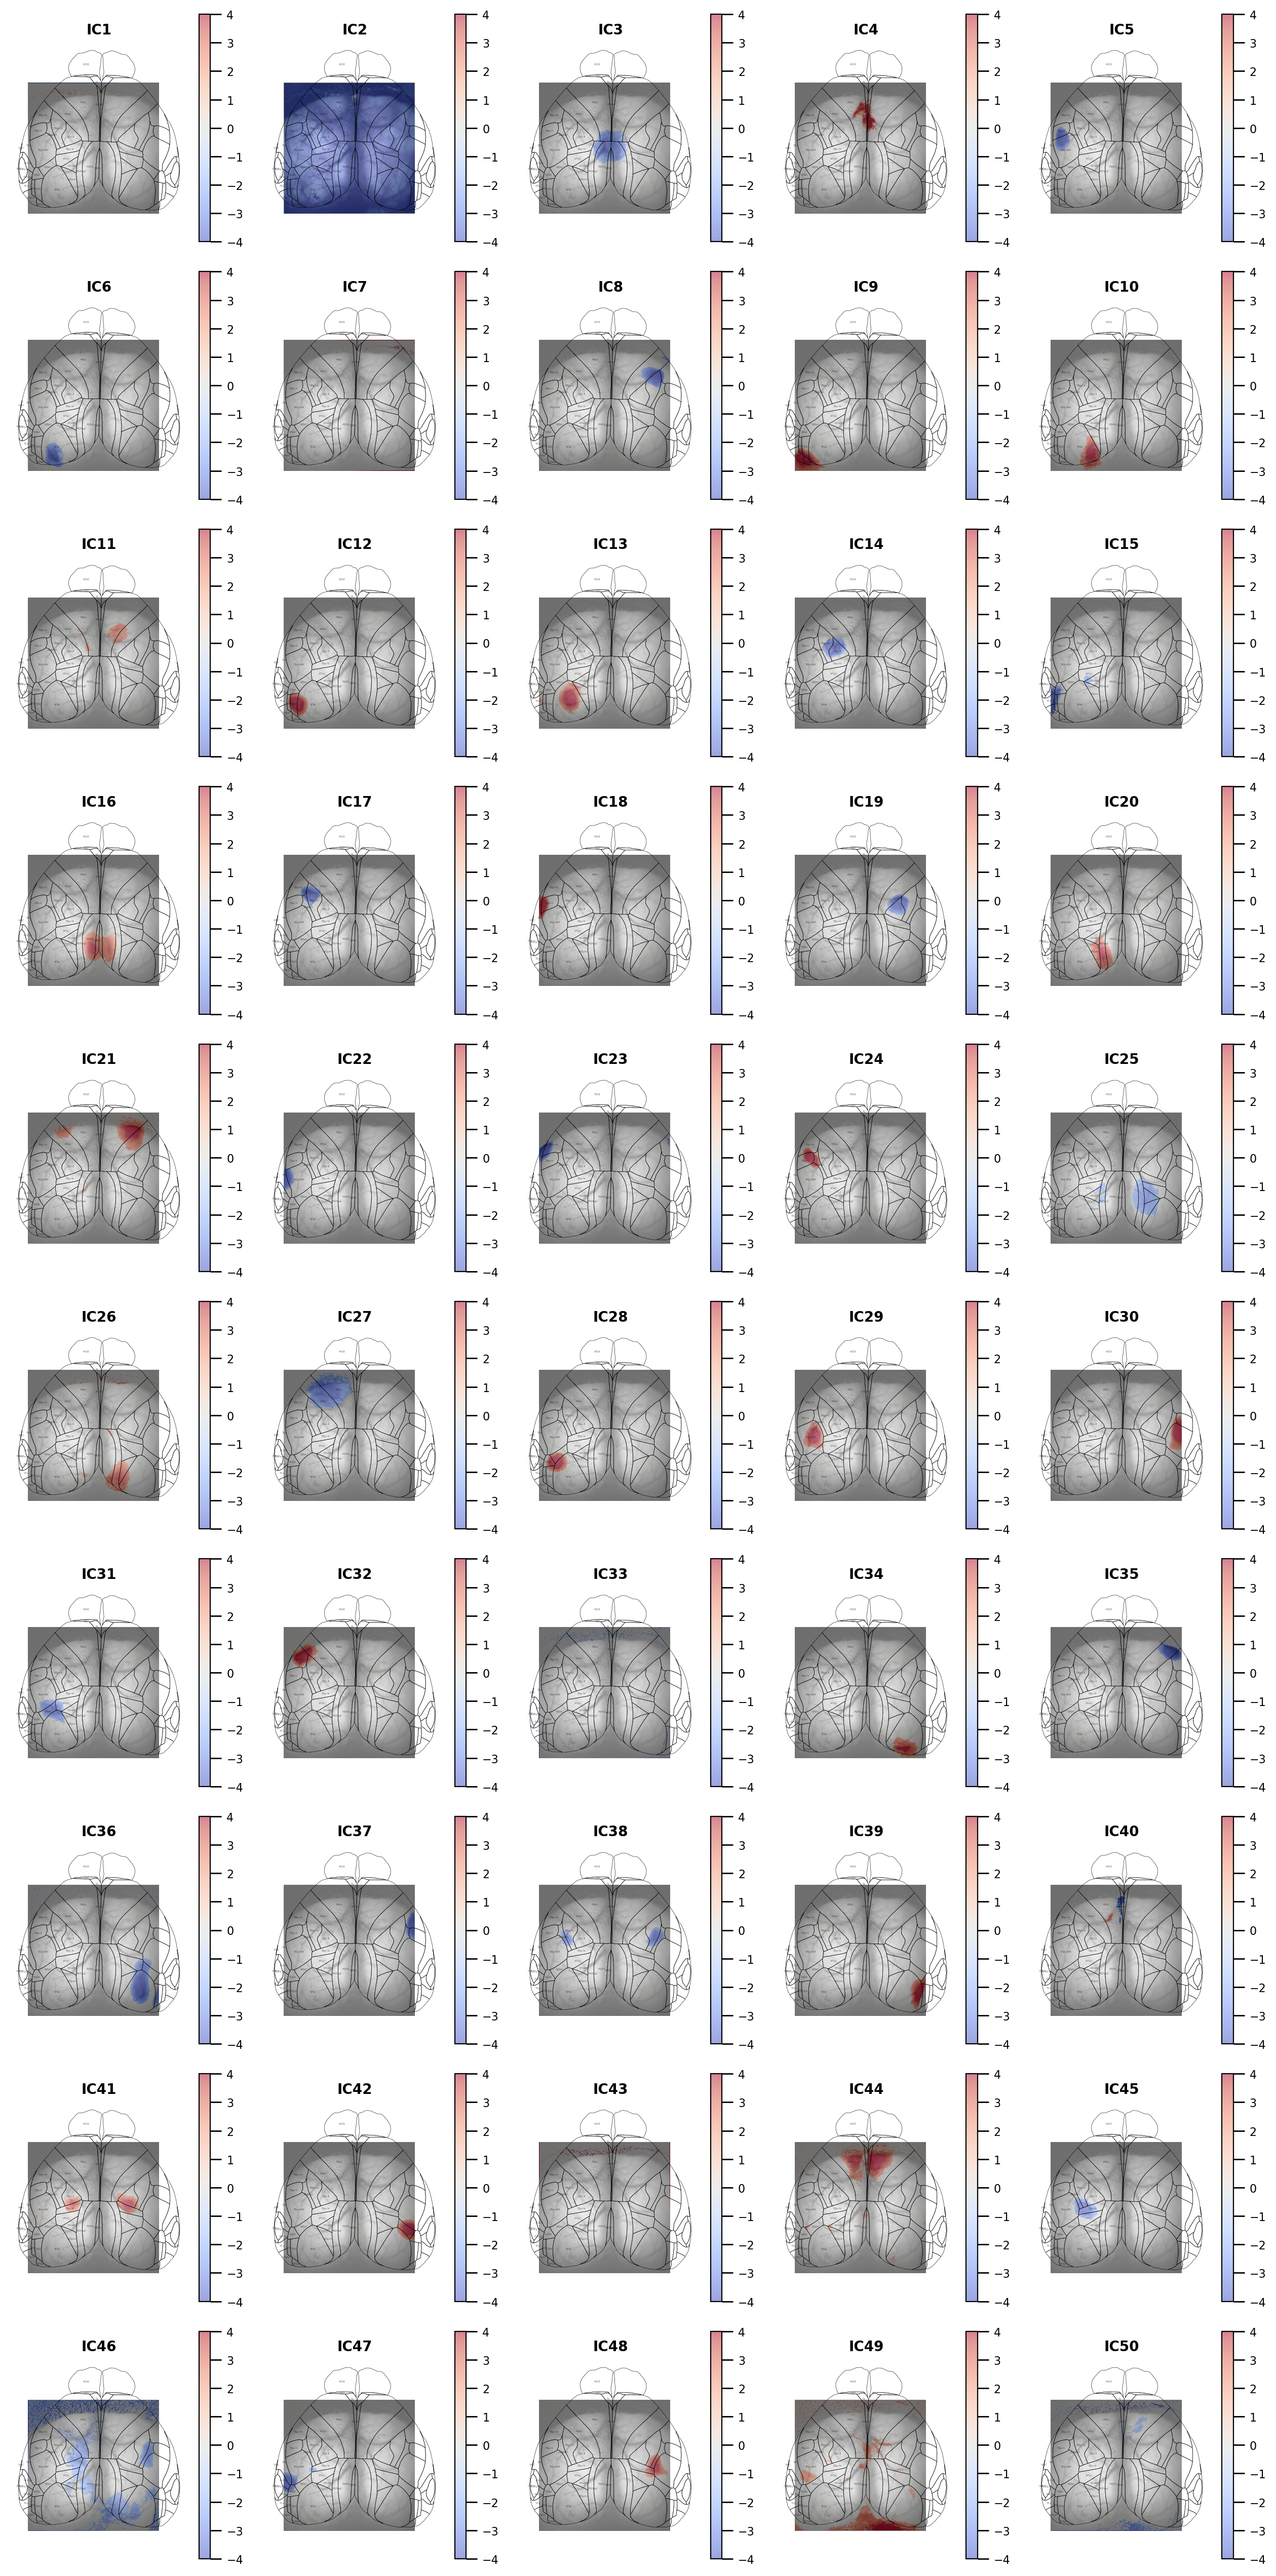

In [16]:
nrow = 10
ncol = 5
dpi = 200

fig, ax = plt.subplots(nrow, ncol, figsize=(U.shape[0] / dpi * ncol, U.shape[1] / dpi * nrow), dpi=dpi)
for irow in range(nrow):
    for icol in range(ncol):
        iIC = irow * ncol + icol
        ax[irow, icol].imshow(frames_ave, cmap='gray')
        img = ax[irow, icol].imshow(IC_arrayz_cut[iIC], cmap='coolwarm', vmax=4, vmin=-4, alpha=0.5)
        ax[irow, icol].set_title('IC{}'.format(iIC + 1), fontsize=10)
        ax[irow, icol].axis('off')

        for idx, r in ccf_regions_im.iterrows():
            ax[irow, icol].plot(r['left_x'], r['left_y'], 'k', lw=0.2)
            ax[irow, icol].plot(r['right_x'], r['right_y'], 'k', lw=0.2)
            ax[irow, icol].text(r.left_center[0], r.left_center[1], r.acronym, color='k', va='center', fontsize=2,
                                alpha=0.5,
                                ha='center')
        fig.colorbar(img)

fig.set_facecolor('white')
plt.tight_layout()
plt.savefig(pjoin(path_out, 'spatial_IC.png'), bbox_inches='tight', pad_inches=0)
plt.show()
